In [101]:
import pandas as pd 
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import dask.dataframe as dd
import json
import sys
import time
from functools import reduce
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, wait
%matplotlib inline
warnings.filterwarnings('ignore')

## Lendo base de dados em CSV

In [102]:
df = pd.read_csv('1429_1.csv')
df.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


## Análise

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
id                      34660 non-null object
name                    27900 non-null object
asins                   34658 non-null object
brand                   34660 non-null object
categories              34660 non-null object
keys                    34660 non-null object
manufacturer            34660 non-null object
reviews.date            34621 non-null object
reviews.dateAdded       24039 non-null object
reviews.dateSeen        34660 non-null object
reviews.didPurchase     1 non-null object
reviews.doRecommend     34066 non-null object
reviews.id              1 non-null float64
reviews.numHelpful      34131 non-null float64
reviews.rating          34627 non-null float64
reviews.sourceURLs      34660 non-null object
reviews.text            34659 non-null object
reviews.title           34655 non-null object
reviews.userCity        0 non-null float64
reviews.userProvince    0

### Como mostra os dados acima, existem 34660 reviews de produtos identificados, mas somente 34658 ids de produto  
### <span style="color:red">TRATAR ISSO</span>

In [104]:
df[['reviews.rating']].describe()

,reviews.rating
count,34627.000000
mean,4.584573
std,0.735653
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## Agrupando produtos por média de nota de review  
Isso será usado para facilitar no cálculo da correlação de produtos mais a frente

In [105]:
products = pd.DataFrame(df.groupby('asins')['reviews.rating'].mean())

In [106]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, B002Y27P3M to B01J4ORNHU
Data columns (total 1 columns):
reviews.rating    38 non-null float64
dtypes: float64(1)
memory usage: 656.0+ bytes


In [107]:
products.head()

,reviews.rating
asins,
B002Y27P3M,NaN
B002Y27P6Y,3.500000
B005PB2T0S,4.000000
B005PB2T2Q,3.666667
B006GWO5NE,4.875000


## Identifica quantas avaliações existem por produto e insere no dataframe

In [108]:
products['number_of_ratings'] = df.groupby('asins')['reviews.rating'].count()
products.head()

,reviews.rating,number_of_ratings
asins,,
B002Y27P3M,NaN,0
B002Y27P6Y,3.500000,10
B005PB2T0S,4.000000,5
B005PB2T2Q,3.666667,6
B006GWO5NE,4.875000,8


In [109]:
products.describe()

,reviews.rating,number_of_ratings
count,38.000000,41.000000
mean,4.411462,844.512195
std,0.568281,2142.269919
min,2.461538,0.000000
25%,4.428623,7.000000
50%,4.557075,15.000000
75%,4.705459,372.000000
max,5.000000,10966.000000


## Visualização da distribuição das notas em produtos

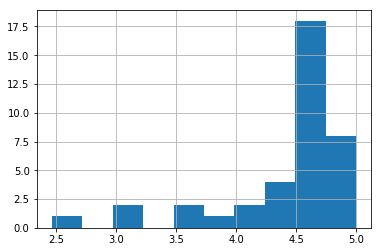

In [110]:
products['reviews.rating'].hist()

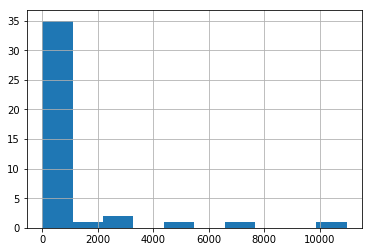

In [111]:
products['number_of_ratings'].hist()

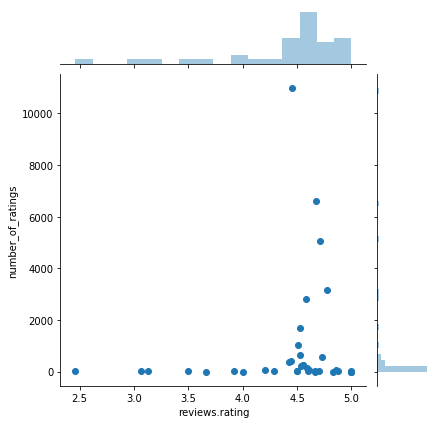

In [112]:
sns.jointplot(x='reviews.rating', y='number_of_ratings', data=products)

## Motor de recomendação
### Criação de uma matriz de produtos com avaliações

In [113]:
df.processed_categories = df.categories.apply(lambda row: row.split(','))
df.processed_categories.head()

0    [Electronics, iPad & Tablets, All Tablets, Fir...
1    [Electronics, iPad & Tablets, All Tablets, Fir...
2    [Electronics, iPad & Tablets, All Tablets, Fir...
3    [Electronics, iPad & Tablets, All Tablets, Fir...
4    [Electronics, iPad & Tablets, All Tablets, Fir...
Name: categories, dtype: object

In [114]:
df.columns

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')

In [115]:
df = df[['name', 'asins', 'brand', 'categories', 'manufacturer', 'reviews.title', 'reviews.text']]
#df = df.drop_duplicates(subset=['asins'])
df.head()

,name,asins,brand,categories,manufacturer,reviews.title,reviews.text
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,Kindle,This product so far has not disappointed. My c...
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,very fast,great for beginner or experienced person. Boug...
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,Beginner tablet for our 9 year old son.,Inexpensive tablet for him to use and learn on...
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,Good!!!,I've had my Fire HD 8 two weeks now and I love...
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,Fantastic Tablet for kids,I bought this for my grand daughter when she c...


In [116]:
df['name'] = df['name'].map(lambda x: re.split(', | \s | \n', str(x).lower()))
df['categories'] = df['categories'].map(lambda x: re.split(', | \&', str(x).lower()))
df.set_index('asins', inplace=True)

In [117]:
df.head()

,name,brand,categories,manufacturer,reviews.title,reviews.text
asins,,,,,,
B01AHB9CN2,"[all-new fire hd 8 tablet, 8 hd display, wi-fi...",Amazon,"[electronics,ipad, tablets,all tablets,fire t...",Amazon,Kindle,This product so far has not disappointed. My c...
B01AHB9CN2,"[all-new fire hd 8 tablet, 8 hd display, wi-fi...",Amazon,"[electronics,ipad, tablets,all tablets,fire t...",Amazon,very fast,great for beginner or experienced person. Boug...
B01AHB9CN2,"[all-new fire hd 8 tablet, 8 hd display, wi-fi...",Amazon,"[electronics,ipad, tablets,all tablets,fire t...",Amazon,Beginner tablet for our 9 year old son.,Inexpensive tablet for him to use and learn on...
B01AHB9CN2,"[all-new fire hd 8 tablet, 8 hd display, wi-fi...",Amazon,"[electronics,ipad, tablets,all tablets,fire t...",Amazon,Good!!!,I've had my Fire HD 8 two weeks now and I love...
B01AHB9CN2,"[all-new fire hd 8 tablet, 8 hd display, wi-fi...",Amazon,"[electronics,ipad, tablets,all tablets,fire t...",Amazon,Fantastic Tablet for kids,I bought this for my grand daughter when she c...


In [123]:
def get_sentiment_score(review):
    if not review.get('reviews.text', False):
        review['reviews.text'] = ''
        return review
    
    try:
        document = types.Document(content=review.get('reviews.text', ''), type=enums.Document.Type.PLAIN_TEXT)
        sentiment_score = client.analyze_entity_sentiment(document=document)
        review['parsed_text'] = [entity.name for entity in sentiment_score.entities if entity.sentiment.score > 0 or not entity.sentiment.score]
    except:
        return review
     
    return review

In [124]:
def get_sentiment_score_title(review):
    if not review.get('reviews.title', False):
        review['parsed_title'] = ''
        return review
    try:
        document = types.Document(content=review.get('reviews.title', ''), type=enums.Document.Type.PLAIN_TEXT)
        sentiment_score = client.analyze_entity_sentiment(document=document)
        review['parsed_title'] = [entity.name for entity in sentiment_score.entities if entity.sentiment.score > 0 or not entity.sentiment.score] 
    except:
        return review
    
    
    return review

In [125]:
%env GOOGLE_APPLICATION_CREDENTIALS=/home/luan/tcc/creds/TTC-PLN-edde7bd554e0.json
client = language.LanguageServiceClient()

env: GOOGLE_APPLICATION_CREDENTIALS=/home/luan/tcc/creds/TTC-PLN-edde7bd554e0.json


In [126]:
#df['reviews.text'].apply(lambda row: get_sentiment_score(str(row)))
dict_dataframe = df.to_dict('records')

In [130]:
pool = ThreadPoolExecutor(50)
#parsed_text_file = open('./parsed_text_file.json', 'w+')
count = 0
success = 0
total = len(dict_dataframe)
list_of_futures = []

for item in dict_dataframe:
    count += 1
    
    if count % 400 == 0:
        time.sleep(60)
        
    #list_of_futures.append(pool.submit(get_sentiment_score, item))
    for future in list_of_futures:
        success += 1
        return_item = future.result()
        list_of_futures.remove(future)
        #parsed_text_file.write(json.dumps(return_item)+'\n')
        
    sys.stdout.write('\r{}/{}({})'.format(success, count, total))
    sys.stdout.flush()

#parsed_text_file.close()

34660/34660(34660)

In [132]:
pool = ThreadPoolExecutor(50)
#parsed_text_file = open('./parsed_text_file_title.json', 'w+')
count = 0
success = 0
total = len(dict_dataframe)
list_of_futures = []
time.sleep(60)
for item in dict_dataframe:
    count += 1
    
    if count % 400 == 0:
        time.sleep(60)
        
    #list_of_futures.append(pool.submit(get_sentiment_score_title, item))
    for future in list_of_futures:
        success += 1
        return_item = future.result()
        list_of_futures.remove(future)
        #parsed_text_file.write(json.dumps(return_item)+'\n')
        
    sys.stdout.write('\r{}/{}({})'.format(success, count, total))
    sys.stdout.flush()

#parsed_text_file.close()

34660/34660(34660)

In [176]:
open_title_file = open('./parsed_text_file_title.json', 'r')
open_text_file = open('./parsed_text_file.json', 'r')

json_data_title = []
json_data_text = []

for line in open_title_file:
    json_data_title.append(json.loads(line))
    
for line in open_text_file:
    json_data_text.append(json.loads(line))
    
df_title = pd.DataFrame.from_dict(json_data_title)
df_text = pd.DataFrame.from_dict(json_data_text)

#df = pd.merge(df_title, df_text, on='asins')
df_title['asins']

KeyError: 'asins'

In [ ]:
df.groupby('asins', as_index=False).agg(lambda x: x.tolist())

In [ ]:
df['bow'] = ''
columns = df[['name', 'brand', 'categories', 'manufacturer', 'reviews.text', 'reviews.title']].columns
for index, row in df.iterrows():
    words = ''
    for col in columns:
        if col not in ['brand', 'manufacturer']:
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    row['bow'] = words
    
df.drop(columns = [col for col in df.columns if col!= 'bow'], inplace = True)

In [ ]:
df.head()

In [ ]:
count = CountVectorizer()
count_matrix = count.fit_transform(df['bow'])

indices = pd.Series(df.index)
indices[:5]

## Matriz de similaridade
$similaridade = cos(\theta) = \dfrac{\boldsymbol{u} \cdot \boldsymbol{v}}{\|{\boldsymbol{u}}\|\|{\boldsymbol{v}}\|} = 
\dfrac{\sum_{i = 1}^n u_iv_i}{\sqrt{\sum_{i = 1}^n u_i^2}\sqrt{\sum_{i = 1}^n v_i^2}}$

In [71]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[ 1.        ,  0.3216121 ,  0.14339019, ...,  0.14740926,
         0.16854997,  0.33658092],
       [ 0.3216121 ,  1.        ,  0.51880524, ...,  0.37249616,
         0.1490712 ,  0.35143175],
       [ 0.14339019,  0.51880524,  1.        , ...,  0.80018803,
         0.26585253,  0.60328004],
       ..., 
       [ 0.14740926,  0.37249616,  0.80018803, ...,  1.        ,
         0.42947785,  0.71469434],
       [ 0.16854997,  0.1490712 ,  0.26585253, ...,  0.42947785,
         1.        ,  0.5547002 ],
       [ 0.33658092,  0.35143175,  0.60328004, ...,  0.71469434,
         0.5547002 ,  1.        ]])

In [72]:
def recommendations(pid, cosine_sim = cosine_sim):
    
    recommended_prds = []
    
    idx = indices[indices == pid].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_5 = list(score_series.iloc[1:6].index)
    
    for i in top_5:
        recommended_prds.append(list(df.index)[i])
        
    return recommended_prds

In [73]:
recommendations('B005PB2T0S')

['B002Y27P6Y', 'B005PB2T2Q', 'B00LW9XOJM', 'B002Y27P3M', 'B01J2G4VBG']